In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import joblib


In [2]:
df = pd.read_csv("/Users/charulagnihotri/Documents/projects/fintech_breakthrough/data/crypto_sentiment_merged.csv")

In [3]:
# Convert sentiment labels to numerical values
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

In [4]:
# Drop original sentiment column
df.drop(columns=["sentiment"], inplace=True)

# Sort by date
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by="date", inplace=True)

In [5]:
# Create moving averages
df["price_7d_avg"] = df["price"].rolling(window=7).mean()
df["price_14d_avg"] = df["price"].rolling(window=14).mean()

# Fill NaN values
df.fillna(method="bfill", inplace=True)

/var/folders/hh/bb1k1l2j6w58bkgff6_mt1km0000gn/T/ipykernel_73123/1539885351.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[["price", "sentiment_score", "price_7d_avg", "price_14d_avg"]])

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=["price", "sentiment_score", "price_7d_avg", "price_14d_avg"])
df_scaled["date"] = df["date"]  # Keep date for reference

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert DataFrame to NumPy array
data = df_scaled[["price", "sentiment_score", "price_7d_avg", "price_14d_avg"]].values

sequence_length = min(30, len(data) - 1)

X, Y = [], []
for i in range(len(data) - sequence_length):
    X.append(data[i : i + sequence_length].flatten())  # Flatten 30 days of data into 1 row
    if i + sequence_length < len(data):
        Y.append(data[i + sequence_length, 0])  # Predict next day price
    else:
        print(f"Skipping index {i + sequence_length}, out of range.")

# Convert to NumPy arrays
X, Y = np.array(X), np.array(Y)

# **Final shape for Random Forest** → (samples, features)
print(f"✅ X Shape: {X.shape} | Samples: {X.shape[0]}, Features: {X.shape[1]}")
print(f"✅ Y Shape: {Y.shape}")

# **Train-Test Split (80-20)**
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

# **Initialize Random Forest Model**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# **Train the Model**
rf_model.fit(X_train, Y_train)

# **Make Predictions**
Y_pred = rf_model.predict(X_test)

# **Evaluation Metrics**
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"📊 Model Performance:")
print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"✅ R-Squared Score (R²): {r2:.4f}")

✅ X Shape: (68, 120) | Samples: 68, Features: 120
✅ Y Shape: (68,)
📊 Model Performance:
✅ Mean Absolute Error (MAE): 0.0953
✅ Mean Squared Error (MSE): 0.0117
✅ Root Mean Squared Error (RMSE): 0.1080
✅ R-Squared Score (R²): -0.9517


In [10]:
# Save the trained model
joblib.dump(rf_model, "random_forest_model.pkl")
print("✅ Model saved as 'random_forest_model.pkl'")

✅ Model saved as 'random_forest_model.pkl'


In [12]:
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)
pd.DataFrame(Y_test, columns=["Y_test"]).to_csv("Y_test.csv", index=False)

/Users/charulagnihotri/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


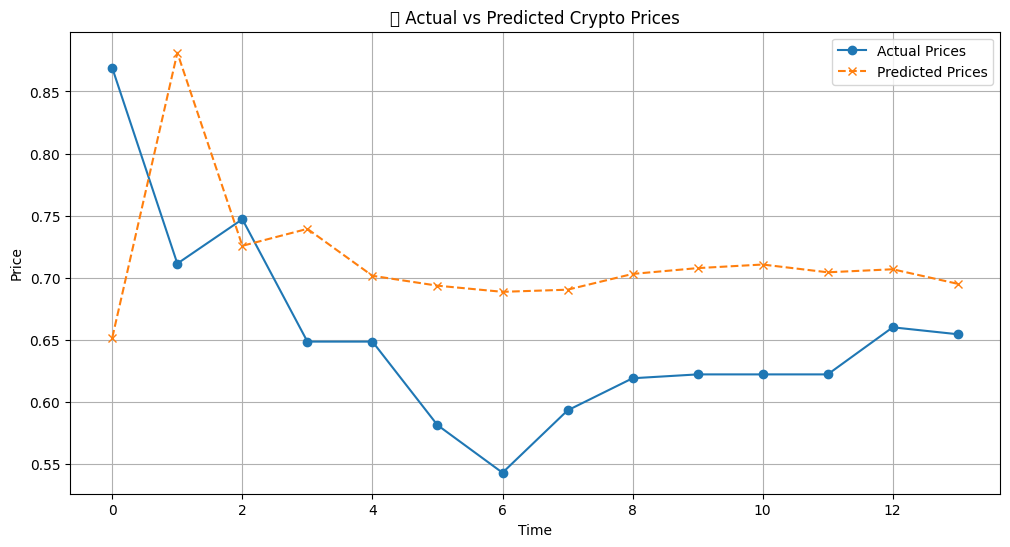

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="Actual Prices", marker='o', linestyle="-")
plt.plot(Y_pred, label="Predicted Prices", marker='x', linestyle="--")

plt.title("📈 Actual vs Predicted Crypto Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

/Users/charulagnihotri/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


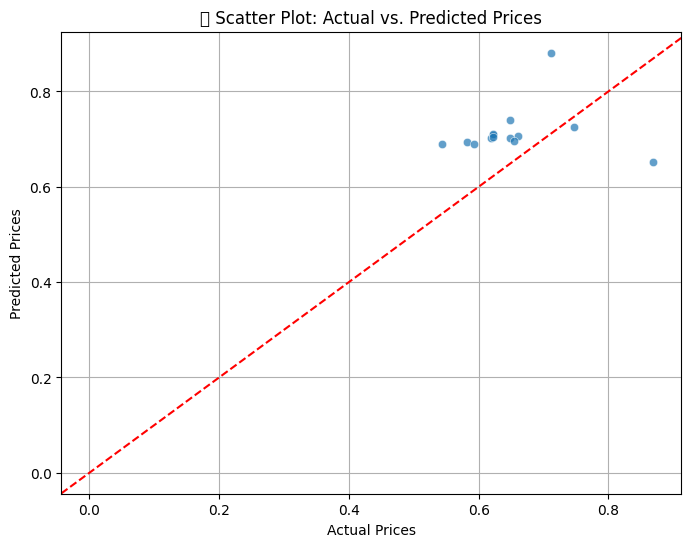

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=Y_pred, alpha=0.7)

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("📊 Scatter Plot: Actual vs. Predicted Prices")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Ideal prediction line
plt.grid()
plt.show()